## SVD and truncation
We previously mentioned that it is often handy to disregard eigenvalues past a certain value, i.e. truncate the SVD to the first, say, $r$ eigenvalues/eigenvectors. How do we decide how big $r$ needs to be. There are two approaches:
1. Energy-based thresholding: given a target of variance to be capturd (e.g. 90%), this method computes the number of eigenvalues/vectors necessary to hit this target.   
2. Hard thresholding: this is based on theory and needs to know (a) the noise level, the dimension of the matrix (Gavish and Donoho "The Optimal Hard Threshold for Singular Values is $4/\sqrt{3}$"). 

The entire premise of Gavish and Donoho is that you can write your data as:

$$
X = X_{\mathrm{true}} + \gamma X_{\mathrm{noise}}
$$

where $X_{\mathrm{noise}}$ is such that $x_{i,j} \sim \mathcal{N}(0, 1)$. Gavish and Donoho realised that the SVD of $X_{\mathrm{noise}}$ allows them to define a noise floor. Therefore, the optimal threshold to exclude noise it to take all the eigenvalues/vectors above the "noise floor".

Let's assume (unrealistically) we know the $\gamma$ and $X$ is square. We will truncate all $\sigma < \tau$ where $\tau = \frac{4}{\sqrt{3}} \gamma \sqrt{n}$ (where $n$ is the dimension of the square matrix).

If $X$ is rectangular and $\gamma$ is unknown. In this case we can calculate the median singular value $\sigma_{\mathrm{med}}$ and the aspect ratio of the matrix $\beta = \frac{n}{m}$ we can infer the noise distribution (i.e. the set of eigenvalues that will only be determined by the noise). From there one can infer the maximum singular value due to noise, and, therefore, the cut-off $\tau = \omega(\beta)\sigma_{\mathrm{med}}$.

To test this, let's create an example for which we know that $X$ ha rank $r=2$ -we'll multiply 2 columns by 2 rows to obtain $X_{\mathrm{true}}$ and them sum this to a known AWGN with intensity $\gamma$ to obtain $$

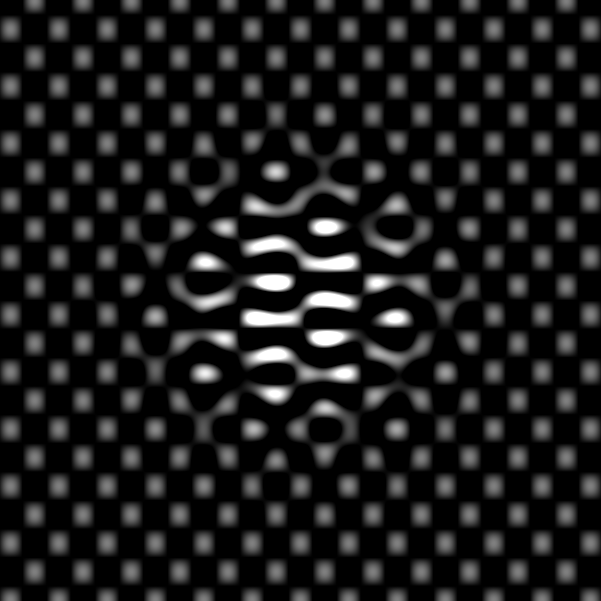

In [21]:
using LinearAlgebra, Images
t = -3:0.01:3

Utrue = [cos.(17*t) .* exp.(-t.^2) sin.(11*t)];
Strue = Diagonal([2 0;0 0.5]);
Vtrue = transpose([sin.(5*t) .* exp.(-t.^2) cos.(13*t)]);

X = Utrue*Strue*Vtrue
Gray.(X)

This matrix is exactly rank 2. Let's now corrupt it with AWGN.

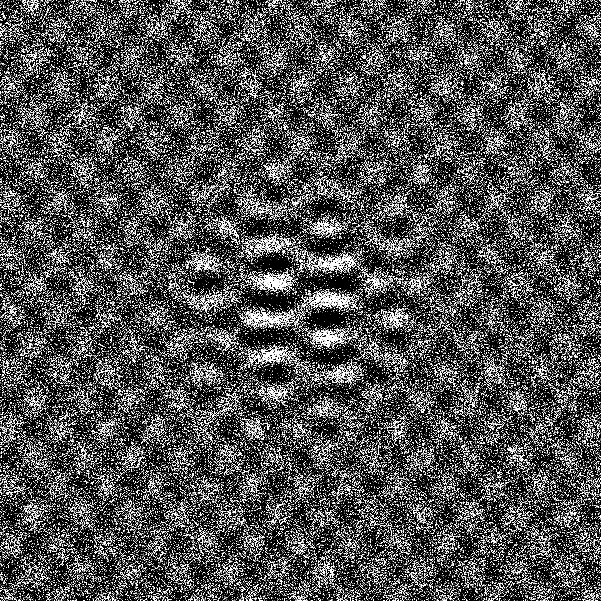

In [22]:
using Random

sigma = 1
Xnoisy = X + sigma * randn(size(X)...)
Gray.(Xnoisy)

Let's now "pretend" we only seen this $X_{\mathrm{noisy}}$ and let's compute its SVD.

In [63]:
U,S,V = svd(Xnoisy, full=false)

N = size(Xnoisy, 1)
cutoff = (4/sqrt(3)) * sqrt(N) * sigma #Gavish Donoho cutoff

_, r = findmax(cumsum(S .> cutoff))
println("The rank of X was: ", r)

The rank of X was: 2


Let's now reconstruct $X$ from these two modes only.

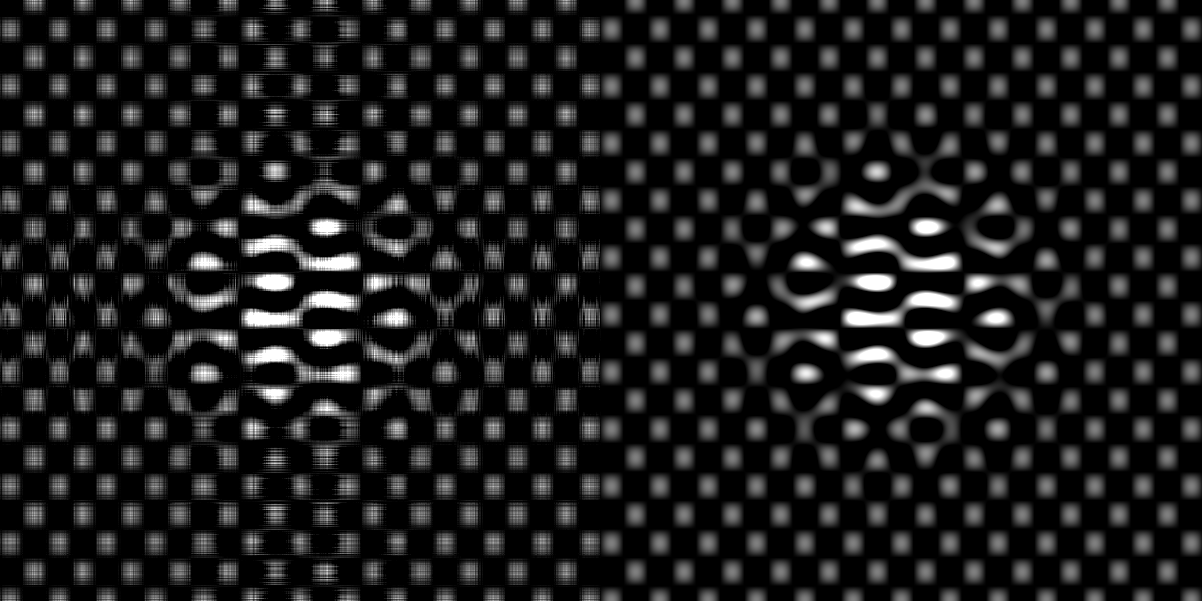

In [64]:
Xclean = U[:,1:r]*Diagonal(S[1:r])*transpose(V[:,1:r])
mosaicview(Gray.(Xclean), Gray.(X), nrow=1, labels=["Reconstructed", "Original"])

For comparison, if we picked the modes that captured say 90% of the energy, we would have got this.

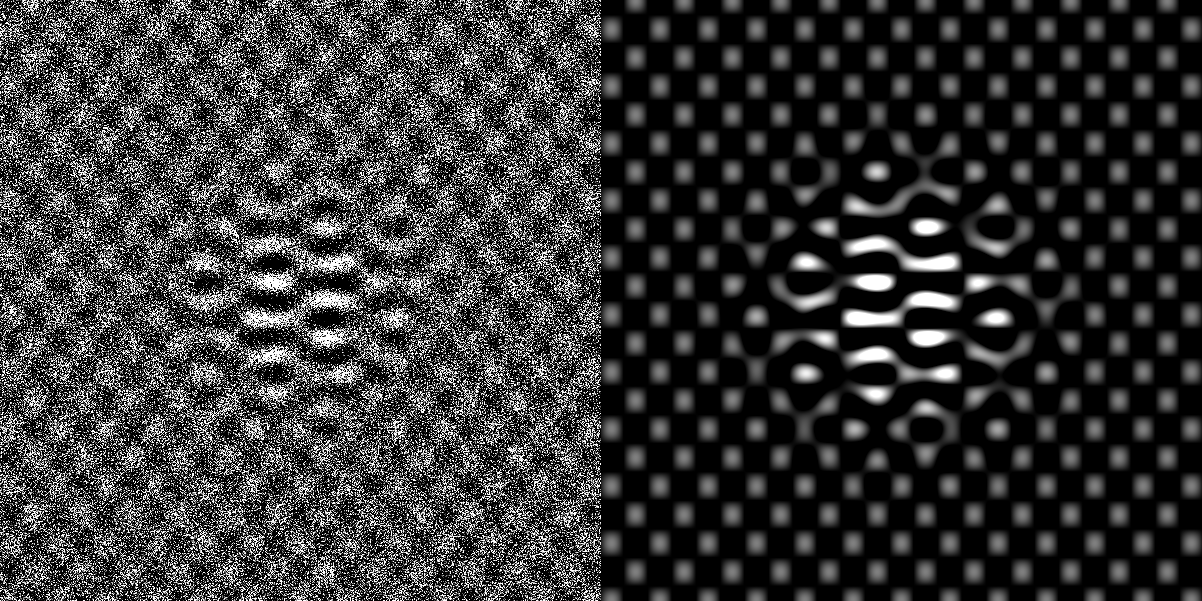

In [70]:
runningSum = cumsum(S)
cutoff = 0.9 * maximum(runningSum)
r90 = argmax(runningSum .> cutoff)

X90 = U[:, 1:r90] *Diagonal(S[1:r90])*transpose(V[:,1:r90])
mosaicview(Gray.(X90), Gray.(X), nrow=1, labels=["Reconstructed", "Original"])

We see that, although we retained 403 vs 2 bases, the reconstruction is sensibly worse that that with 2. This makes sense as the 401 additional orthonormal components of the basis *we know* only contribute noise!.